In [1]:
import cv2,os
from skimage import io
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve

import torch
from torch.utils.data import random_split,Dataset,DataLoader,SubsetRandomSampler
from torch.utils.data import Dataset,TensorDataset,random_split,SubsetRandomSampler
from torch.utils.data.dataset import Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [114]:
chip="H3K27ac"
X_Ctrl = np.load("./Datasets/Ctrl_"+chip+".npy",allow_pickle=True)
X_VPA = np.load("./Datasets/VPA_"+chip+".npy",allow_pickle=True)
y_Ctrl = torch.zeros(len(X_Ctrl), dtype=torch.int64)
y_VPA = torch.ones(len(X_VPA), dtype=torch.int64)
X = np.concatenate((X_Ctrl, X_VPA), axis = 0)
y = torch.cat((y_Ctrl, y_VPA), 0)

# 2. Data processing

In [115]:
class cell_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]).to(torch.float), F.one_hot(self.y[idx],num_classes=2).to(torch.float)

dataset = cell_dataset(X, y)

# 3. ResNet model

In [126]:
modelpath="/groups/4/gaa50089/acd13264yb/Epigenetic/Classification/Models/"

resnet="Resnet10_noavg"
weight=torch.load(modelpath+resnet+"_"+chip+".pkl")
print(modelpath+resnet+"_"+chip+".pkl")

/groups/4/gaa50089/acd13264yb/Epigenetic/Classification/Models/Resnet10_noavg_H3K27ac.pkl


In [127]:
if resnet=="Resnet10_noavg":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.avgpool = nn.Sequential()
            self.resnet.fc = nn.Linear(128*75*75, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
elif resnet=="Resnet10":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.fc = nn.Linear(128, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
elif resnet=="Resnet18":
    class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.fc = nn.Linear(512, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
    
model = ResNet().to(device)

/home/acd13264yb/python7_env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 4. Define Training and Validation

In [128]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

def train(model,device,dataloader_train,loss_function,optimizer):
    losses_train = []
    n_train = 0
    acc_train = 0
    optimizer.step()
    model.train()
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        acc_train += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_train.append(loss.tolist())
    return np.mean(losses_train), (acc_train/n_train)
        
def valid(model,device,dataloader_valid,loss_function):
    losses_valid = []
    n_val = 0
    acc_val = 0
    model.eval()
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_valid.append(loss.tolist())
    return np.mean(losses_valid), (acc_val/n_val)

history = {'loss_train': [], 'loss_valid': [],'acc_train':[],'acc_valid':[]}

# 5. Train by KFold of Cross Validation

In [132]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_function = nn.BCELoss()

splits=KFold(n_splits=5,shuffle=True,random_state=42)
batch_size = 128
n_epochs = 1
    
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    dataloader_train = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    dataloader_valid = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

    model = ResNet().to(device)
    ngpu = 4
    if (device.type == 'cuda') and (ngpu > 1):
        model = nn.DataParallel(model, list(range(ngpu)))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    for epoch in range(n_epochs):
        loss_train, acc_train = train(model,device,dataloader_train,loss_function,optimizer)
        loss_valid, acc_valid = valid(model,device,dataloader_valid,loss_function)
        scheduler.step()
        print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
              .format(epoch, loss_train, acc_train, loss_valid, acc_valid))
        
        history['loss_train'].append(loss_train)
        history['loss_valid'].append(loss_valid)
        history['acc_train'].append(acc_train)
        history['acc_valid'].append(acc_valid)

In [ ]:
loss_train_avg = np.zeros(n_epochs)
loss_valid_avg = np.zeros(n_epochs)
acc_train_avg = np.zeros(n_epochs)
acc_valid_avg = np.zeros(n_epochs)
for num in range(5):
    loss_train = history['loss_train'][num*n_epochs:(num+1)*n_epochs]
    loss_valid = history['loss_valid'][num*n_epochs:(num+1)*n_epochs]
    acc_train = history['acc_train'][num*n_epochs:(num+1)*n_epochs]
    acc_valid = history['acc_valid'][num*n_epochs:(num+1)*n_epochs]
    loss_train_avg+=loss_train
    loss_valid_avg+=loss_valid
    acc_train_avg+=acc_train
    acc_valid_avg+=acc_valid
    
    plt.ylim(0,1.0)
    plt.plot(range(1,n_epochs+1), acc_train, 'b', label='Training accuracy')  
    plt.plot(range(1,n_epochs+1), acc_valid, 'r', label='Validation accuracy')
    plt.title("Fold "+str(num)+' Training and Validation accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
loss_train_avg = loss_train_avg/5
loss_valid_avg = loss_valid_avg/5
acc_train_avg = acc_train_avg/5
acc_valid_avg = acc_valid_avg/5
plt.ylim(0,1.0)
plt.plot(range(1,n_epochs+1), acc_train_avg, 'b', label='Training accuracy')  
plt.plot(range(1,n_epochs+1), acc_valid_avg, 'r', label='Validation accuracy')
plt.title(' Average Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# 4. valid data

total_test: 451
accuracy_score: 0.996
precision_score: 1.000
roc_auc_score: 1.000


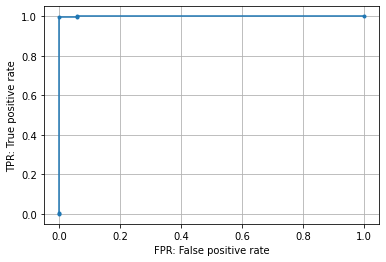

In [77]:
y_true = []
y_pred = []
out_pred = []
total = 0

model.eval()
for x, y in dataloader_valid:
    total += y.size()[0]
    x = x.to(device)  # テンソルをGPUに移動
    y = y.to(device)
    output = model.forward(x)  # 順伝播
    for i in range(y.size()[0]):
        out_pred.append(output[i][1].item())
        y_pred.append(output.argmax(1)[i].item())
        y_true.append(y[i][1].item())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
out_pred = np.array(out_pred) 
print(chip)
print(resnet)
print('accuracy_score: {:.3f}'.format(accuracy_score(y_true,y_pred)))
print('precision_score: {:.3f}'.format(precision_score(y_true,y_pred)))
print('roc_auc_score: {:.3f}'.format(roc_auc_score(y_true, out_pred)))
print("total_test: {:}" .format(total))
fpr, tpr, thresholds = roc_curve(y_true, out_pred,drop_intermediate=True)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 99. Save model

In [50]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.module.resnet.state_dict(),"Models/Resnet17C1F.pkl")

In [13]:
# model.fc = nn.Sequential(
#     nn.Linear(128, 512),
#     nn.Dropout(p=0.5),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, 2)
# )

# #Freeze model weights
# for param in model.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True